In [147]:
import numpy as np
import pandas as pd
import scipy.linalg as spl
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 15)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
sns.set(font_scale=1.3)
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")

Загрузите все изображения с помощью `plt.imread` и визуализируйте некоторые из них. Каждое изображение — матрица размера 170×250.

In [54]:
num_images = 1584
n = 170
m = 250
images = np.array([plt.imread(f'scaled_images/{i}.jpg') for i in tqdm(range(1, num_images + 1))])
images.shape

100%|██████████| 1584/1584 [00:01<00:00, 1501.07it/s]


(1584, 170, 250)

In [55]:
images = images.reshape((images.shape[0], -1))
images.shape

(1584, 42500)

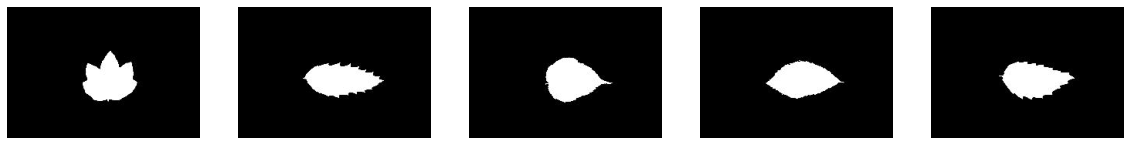

In [56]:
num_show = 5
plt.figure(figsize=(20, 3))
for i in range(num_show):
    rand = np.random.randint(1, num_images)
    plt.subplot(1, num_show, i + 1)
    plt.imshow(images[rand].reshape((n, m)), cmap='gray')
    plt.axis('off')
plt.show()

В файле `train_labels.csv` указаны номера образцов листьев, которые относятся к обучающей части данных, а так же их виды. Разделите данные на обучающую и тестовую часть.

In [73]:
data = pd.read_csv('train_labels.csv')
le = LabelEncoder()
data['encoded species'] = le.fit_transform(data['species'])
data

,id,species,encoded species
0,1,Acer_Opalus,3
1,2,Pterocarya_Stenoptera,49
2,3,Quercus_Hartwissiana,65
3,5,Tilia_Tomentosa,94
4,6,Quercus_Variabilis,84
...,...,...,...
985,1575,Magnolia_Salicifolia,40
986,1578,Acer_Pictum,5
987,1581,Alnus_Maximowiczii,11
988,1582,Quercus_Rubra,78


In [58]:
id_test_arr = np.setdiff1d(np.linspace(1, num_images, num_images), data['id'].to_numpy())
id_test_arr.shape

(594,)

In [59]:
images_train = []
for id_train in data['id']:
    images_train.append(images[id_train - 1])
images_test = []
for id_test in id_test_arr:
    images_test.append(images[int(id_test) - 1])
    
images_train = np.array(images_train)
images_test = np.array(images_test)
images_train.shape, images_test.shape

((990, 42500), (594, 42500))

На обучающей части данных постройте 30 главных компонент. Какую долю дисперсии данных они объясняют? Какую долю дисперсии объясняет каждая компонента отдельно?

In [132]:
n_comp = 30
pca = PCA(n_components=n_comp)
transform_train = pca.fit_transform(images_train)
hat_train = pca.inverse_transform(transform_train)

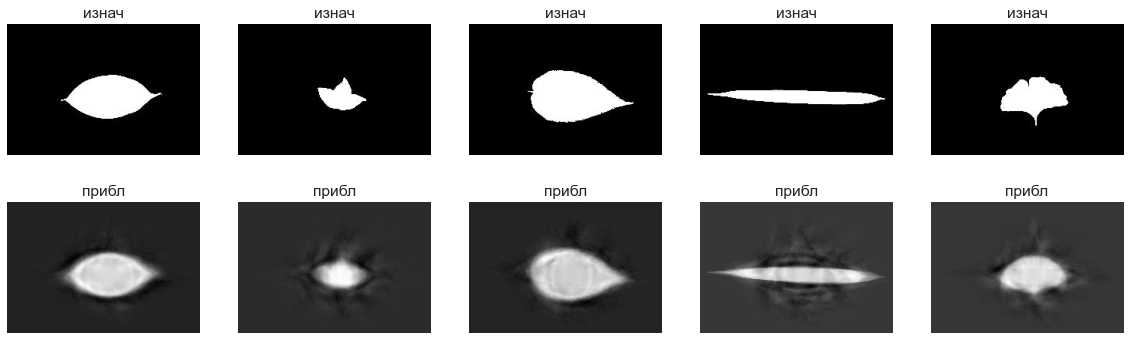

In [133]:
num_show = 5
plt.figure(figsize=(20, 6))
for i in range(num_show):
    rand = np.random.randint(1, images_train.shape[0])
    plt.subplot(2, num_show, i + 1)
    plt.imshow(images_train[rand].reshape((n, m)), cmap='gray')
    plt.title('изнач')
    plt.axis('off')
    plt.subplot(2, num_show, num_show + i + 1)
    plt.imshow(hat_train[rand].reshape((n, m)), cmap='gray')
    plt.title('прибл')
    plt.axis('off')
plt.show()

In [134]:
singular_values = np.sqrt(spl.svdvals(images_train))
print(singular_values)

[626.32513  346.54385  323.92133  253.09218  242.94394  217.13441
 206.48851  189.97104  183.85915  174.06927  172.10083  169.31168
 164.10927  159.99547  156.40558  154.73671  149.18805  146.15659
 145.27023  144.44145  140.50986  140.09213  138.1693   136.61371
 135.80968  133.52303  132.3371   130.07855  128.69159  125.47882
 124.9067   123.11372  122.57506  122.373764 120.03625  119.37985
 118.627396 117.97004  117.85597  116.4287   114.719315 113.62053
 113.42794  112.62661  111.59317  111.159615 110.54165  109.70944
 109.292015 108.43238  107.85468  107.42228  106.89665  106.38418
 105.61846  105.278885 104.68369  104.42169  103.886086 103.53913
 102.64439  101.78476  101.38407  100.69416  100.511375 100.29267
  99.88501   99.65031   98.84689   98.34458   98.05799   97.88131
  97.47401   97.25663   96.8876    96.19336   95.90729   95.724014
  95.35955   95.26594   94.887726  94.41531   93.992165  93.36305
  93.03186   92.707886  92.4062    92.0961    91.83107   91.50374
  91.2132

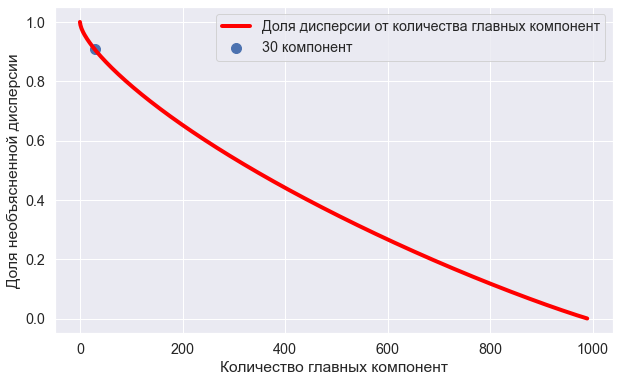

доля необъясненной дисперсии для 30 компонент: 0.9072554111480713


In [135]:
error = singular_values[::-1].cumsum() / singular_values.sum()
error = error[::-1]

plt.figure(figsize=(10, 6))
plt.plot(range(len(error)), error, c='red', linewidth=4, label='Доля дисперсии от количества главных компонент')
plt.scatter(n_comp, error[n_comp - 1], label='30 компонент', s=100)
plt.xlabel('Количество главных компонент')
plt.ylabel('Доля необъясненной дисперсии')
plt.legend()
plt.show()
print(f'доля необъясненной дисперсии для 30 компонент: {error[n_comp - 1]}')

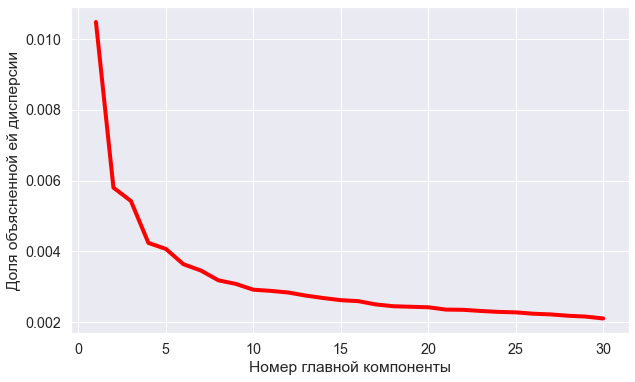

In [136]:
explained_one_component = singular_values[:n_comp] / singular_values.sum()
plt.figure(figsize=(10, 6))
plt.plot(np.linspace(1, n_comp, n_comp), explained_one_component, c='red', linewidth=4)
plt.xlabel('Номер главной компоненты')
plt.ylabel('Доля объясненной ей дисперсии')
plt.show()

Визуализируйте главные компоненты. Можете ли вы их как-то охарактеризовать?

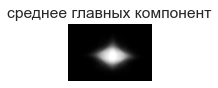

главные компоненты по убыванию


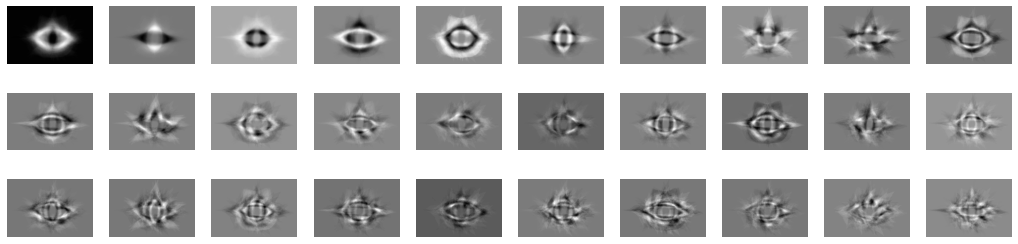

In [137]:
plt.figure(figsize=(1.5, 1.5))
plt.imshow(pca.mean_.reshape((n, m)), cmap='gray')
plt.axis('off')
plt.title('среднее главных компонент')
plt.show()

print('главные компоненты по убыванию')
plt.figure(figsize=(18, 4.5))    
for i in range(n_comp):
    plt.subplot(int(n_comp / 10), 10, i + 1)
    plt.imshow(pca.components_[i].reshape((n, m)), cmap='gray')
    plt.axis('off')

Среднее главных компонент выдает осмысленную картину с формой, похожей на довольно много элементов выборки. Также можно заметить, что чем важнее главная компонента (меньше ее номер), тем осмысленнее получается изображение.

Визуализируйте обучающую часть данных в проекции на две первых главных компоненты. Цвет точки должен соответствовать виду образца. Используйте `cmap='Set1'` во избежании градации цвета по номеру вида. Наблюдаются ли какие-либо закономерности?

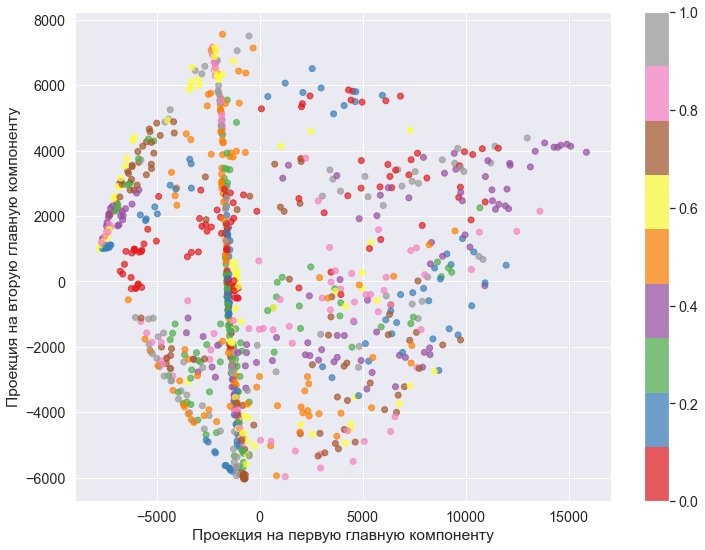

In [138]:
plt.figure(figsize=(12, 9))
plt.scatter(transform_train[:, 0], transform_train[:, 1], 
            alpha=0.7, c=data['encoded species'] / data['encoded species'].max(), cmap='Set1')
plt.xlabel('Проекция на первую главную компоненту')
plt.ylabel('Проекция на вторую главную компоненту')
plt.colorbar()
plt.show()

In [139]:
len(np.unique(data['encoded species'].to_numpy()))

99

Честно говоря, очень трудно заметить закономерности среди огромного количества таргетов (99), которые, вдобавок ко всему еще и плохо разделимы. Однако можно заметить, что очень много элементов выборки с разными таргетами "выстроились" почти в вертикальную линию в районе проекции на первую компоменту -1000. Также на самом деле возникает проблема с тем, что в той палитре, которая была нам дана, только 9 цветов, то есть, около 10 таргетов с близкими номерами объединились в один цвет (на самом деле, непонятно, что хуже: иметь линейную зависимость цвета от таргета или объединять несколько таргетов с близкими номерами в один цвет).

Посчитайте и визуализируйте матрицу коэффициентов корреляции Пирсона между проекциями на несколько первых главных компонент. В клетке с индексом (i, j) должен быть коэффициент корреляции Пирсона между проекциями на i-ую и j-ую главные компоненты. Можете ли вы объяснить полученный эффект теоретически?

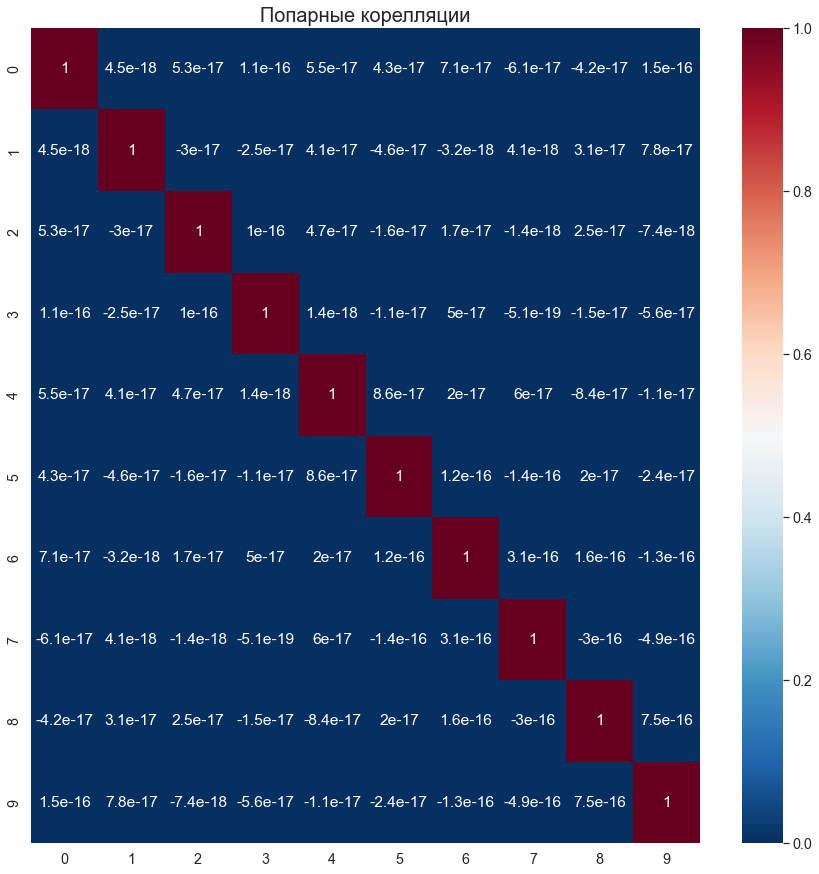

In [142]:
num_corr = 10

corr_components = transform_train[:, :num_corr]
df = pd.DataFrame(corr_components)
corr = df.corr(method='pearson')
plt.figure(figsize=(15, 15))
sns.heatmap(corr, cmap='RdBu_r', annot=True)
plt.title('Попарные корелляции', fontsize=20)
plt.show()

Ожидаемо матрица получилась очень близка к единичной. Это хорошо соотносится с теорией, так как оценка матрицы ковариаций проекций &mdash; это диагональная матрица, имеющая на диагоналях собственные числа исходной матрицы ковариаций.

По проекциям данных на первые 30 главных компонент обучите многоклассовую классификацию. Для образцов из тестовой части данных оцените вероятности принадлежности к классам.

В качестве классификатора рассмотрим `RandomForestClassifier`.

In [143]:
transform_test = pca.transform(images_test)

In [144]:
rf = RandomForestClassifier()
rf.fit(transform_train, data['species'])
probas = rf.predict_proba(transform_test)
probas

array([[0.  , 0.  , 0.  , ..., 0.1 , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.02],
       [0.  , 0.1 , 0.02, ..., 0.03, 0.  , 0.02],
       ...,
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.01, ..., 0.1 , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ]])

В таком виде ничего не понятно, так как объектов и таргетов слишком много. Давайте посмотрим, насколько уверенно модель предсказывает самый вероятный класс на первых 5 объектах теста.

In [145]:
for i, p in enumerate(probas[:5]):
    print(f'{i}-й объект теста')
    print(f'самый вероятный класс: {le.inverse_transform([np.argmax(p)])[0]}')
    print(f'вероятность самого вероятного класса: {np.max(p)}')

0-й объект теста
самый вероятный класс: Quercus_Agrifolia
вероятность самого вероятного класса: 0.39
1-й объект теста
самый вероятный класс: Quercus_Kewensis
вероятность самого вероятного класса: 0.38
2-й объект теста
самый вероятный класс: Acer_Circinatum
вероятность самого вероятного класса: 0.1
3-й объект теста
самый вероятный класс: Castanea_Sativa
вероятность самого вероятного класса: 0.61
4-й объект теста
самый вероятный класс: Alnus_Viridis
вероятность самого вероятного класса: 0.37


Как мы видим, модель не очень уверена в своих предсказаниях. Мне кажется, это происходит из-за того, что таргетов слишком много, и они плохо разделимы. Однако давайте воспользуемся `RandomizedSearchCV`, найдем оптимальные параметры, посмотрим на многоклассовую *f1-меру* и сделаем вывод, насколько хорошо модель предсказывает таргеты.

In [171]:
rs = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=666), 
                       param_distributions={
        'max_depth': np.concatenate((np.linspace(1, 50, 50), np.array([None]))), 
        'n_estimators': np.linspace(1, 100, 100, dtype=int),
    }, verbose=2, error_score=f1_micro, n_iter=30, return_train_score=True
)

In [172]:
transform_train.shape, data['species'].to_numpy().shape

((990, 30), (990,))

In [173]:
rs.fit(transform_train, data['species'])

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END ....................max_depth=15.0, n_estimators=83; total time=   0.4s
[CV] END ....................max_depth=15.0, n_estimators=83; total time=   0.4s
[CV] END ....................max_depth=15.0, n_estimators=83; total time=   0.4s
[CV] END ....................max_depth=15.0, n_estimators=83; total time=   0.4s
[CV] END ....................max_depth=15.0, n_estimators=83; total time=   0.4s
[CV] END ....................max_depth=18.0, n_estimators=88; total time=   0.4s
[CV] END ....................max_depth=18.0, n_estimators=88; total time=   0.5s
[CV] END ....................max_depth=18.0, n_estimators=88; total time=   0.5s
[CV] END ....................max_depth=18.0, n_estimators=88; total time=   0.5s
[CV] END ....................max_depth=18.0, n_estimators=88; total time=   0.5s
[CV] END ....................max_depth=None, n_estimators=87; total time=   0.5s
[CV] END ....................max_depth=None, n_

[CV] END ....................max_depth=34.0, n_estimators=96; total time=   0.5s
[CV] END ....................max_depth=34.0, n_estimators=96; total time=   0.5s
[CV] END ....................max_depth=34.0, n_estimators=96; total time=   0.5s
[CV] END ....................max_depth=34.0, n_estimators=96; total time=   0.5s
[CV] END .....................max_depth=9.0, n_estimators=83; total time=   0.3s
[CV] END .....................max_depth=9.0, n_estimators=83; total time=   0.3s
[CV] END .....................max_depth=9.0, n_estimators=83; total time=   0.3s
[CV] END .....................max_depth=9.0, n_estimators=83; total time=   0.3s
[CV] END .....................max_depth=9.0, n_estimators=83; total time=   0.3s
[CV] END ....................max_depth=None, n_estimators=52; total time=   0.2s
[CV] END ....................max_depth=None, n_estimators=52; total time=   0.2s
[CV] END ....................max_depth=None, n_estimators=52; total time=   0.2s
[CV] END ...................

RandomizedSearchCV(error_score=0.5766129032258065,
                   estimator=RandomForestClassifier(random_state=666),
                   n_iter=30,
                   param_distributions={'max_depth': array([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0,
       13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0,
       24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0,
       35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42....
                                        'n_estimators': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84

Метрики показывают, что модель предсказывает таргет правильно примерно в 50% случая, что, как мне кажется, довольно хорошо в сложившейся ситуации (так как очень много таргетов, и они плохо разделимы). Видимо, по 30 таргетам модель смогла неплохо обучиться и предсказывать правильный класс хотя бы в половине случаев.